In [1]:
import juliacall, juliatorch
from juliacall import JuliaError
import torch
from chirho.contrib.experiments.fishery.build_f import build_steady_state_f, build_temporal_f
import pyro
import pyro.distributions as dist
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import seaborn as sns

pyro.settings.set(module_local_params=True)

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preliminary Setup

In [2]:
# Define helpers that take fishing mortality rates, a parameter dict, and initial biomass, and flattens
#  everything into a single tensor that can be passed to a juliatorch JuliaFunction.
def flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    ps = parameters
    return torch.cat(
        [
            initial_biomass,
            torch.stack([
                ps["r1"],
                ps["k1"],
                ps["p12"],
                ps["d1"],
                torch.abs(fishing_mortality_rates[0]),
                ps["r2"],
                ps["e12"],
                ps["p23"],
                ps["d2"],
                torch.abs(fishing_mortality_rates[1]),
                ps["r3"],
                ps["e23"],
                ps["m3"],
                torch.abs(fishing_mortality_rates[2]),
            ]).squeeze()
        ]
    )

def flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times):
    return torch.cat([flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates), times])

In [3]:
# Construct the python function interface to the underlying julia solver
#  of the Zhou and Smith's fishery model (2017)
fishery_steady_state_solver = build_steady_state_f()
fishery_temporal_solver = build_temporal_f()

In [4]:
# Parameters used by Zhao and Smith (2017). We treat these as the true values.
TRUEVALS = OrderedDict(
    k1=1000.0, r1=2.0, r2=1.0, r3=0.25, p12=0.5, p23=0.5, d1=100.0, d2=10.0, e12=0.2, e23=0.2, m3=0.01
)
for k, v in TRUEVALS.items():
    TRUEVALS[k] = torch.tensor(v).double()

# Used to scale up approximately growth proportional fishing rates to absolute fishing rates.
# Note that these are fixed quantities serving only to transform 0-1 fishing rate parameters to absolute rates.
# TODO is this scaling still happening? What is the fishing rate parameter space?
APPROX_GROWTH_RATES = torch.tensor([TRUEVALS["r1"], TRUEVALS["r2"], TRUEVALS["r3"]]).double()
NUM_SPECIES = 3

In [5]:
# Approximate equilibrium biomass for the unfished case.
B_UNFISHED = torch.tensor([958.833, 174.356, 33.476]).double()

In [6]:
def fishery_steady_state(parameters, initial_biomass, fishing_mortality_rates):
    biomass_eq = fishery_steady_state_solver(flatten_for_steady_state(parameters, initial_biomass, fishing_mortality_rates))
    # Sometimes the solver goes infinitesimally negative, which can break logs.
    return torch.relu(biomass_eq) + 1e-10
    
    # # FIXME HACK above is unstable, so just do the fishery temporal solver for a long ways in the future.
    # return torch.relu(fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, torch.tensor([10000.0]))[:, -1])

def fishery_at_times(parameters, initial_biomass, fishing_mortality_rates, times):
    return fishery_temporal_solver(flatten_for_temporal(parameters, initial_biomass, fishing_mortality_rates, times))

### Exploitative Fishing

The narrative begins with exploitative fishing that only considers the maximum sustainable revenue (MSR). For simplicity here, we assume the true parameters are known, and the MSR policy is identified based on those parameters. This policy runs for a number of years, and the biomass is noisily observed at the end of each year.

In [7]:
# Define we dub the maximum sustainable revenue, assuming fixed market prices.
PRICES = torch.tensor([1.0, 20.0, 100.0]).double()

def gross_revenue(biomass, mortality, prices):
    return (biomass * torch.abs(mortality) * prices).sum()

In [8]:
# Use scipy optimize and the true parameter values to find the MSR fishing rates.
def find_msr_fishing_rates(truevals, initial_biomass, prices):
    def objective(mortality_proportions: np.ndarray):
        mortality_rates = torch.tensor(mortality_proportions).double() * APPROX_GROWTH_RATES
        ss = fishery_steady_state(truevals, initial_biomass, mortality_rates)
        msr = gross_revenue(ss, mortality_rates, prices).sum()
        return -msr

    return optimize.minimize(objective, x0=np.array([0.1, 0.1, 0.1]), bounds=[(0.0, 1.0)] * 3).x

In [9]:
msr_rates = torch.tensor(find_msr_fishing_rates(TRUEVALS, B_UNFISHED, PRICES)).double() * APPROX_GROWTH_RATES

In [10]:
# Plot the biomass over time under the MSR policy.
expl_times = torch.arange(0, 5, 0.5)
expl_biomass_at_times = fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, expl_times)

In [11]:
# DEBUG
# fishery_steady_state(TRUEVALS, B_UNFISHED, msr_rates)

In [12]:
# DEBUG
# fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, torch.tensor([0.0, 0.5, 1.0, 10000.0]))

In [13]:
#DEBUG
# torch.abs(fishery_at_times(TRUEVALS, B_UNFISHED, msr_rates, torch.tensor([10000.0]))[:, -1])

In [14]:
def plot_biomass_over_time(times, biomass_at_times, logscale=True, show=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, biomass_at_times[0], label="Forage")
    ax.plot(times, biomass_at_times[1], label="Intermediate")
    ax.plot(times, biomass_at_times[2], label="Apex", color="g")
    if logscale:
        ax.set_yscale("log")
    ax.set_ylabel("Biomass")
    ax.set_xlabel("Time")
    ax.legend()
    if show:
        plt.show()
    return fig, ax

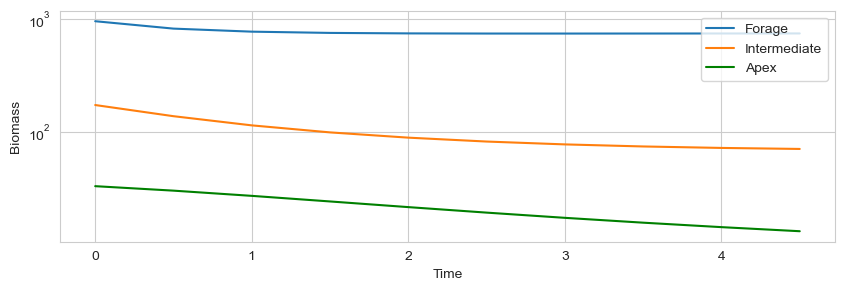

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [15]:
plot_biomass_over_time(expl_times, expl_biomass_at_times)

### Pause on Fishing

The exploitative period ended after concerns developed around the downspin in apex predator numbers. The fishery is paused for a period of time, and the biomass is observed with more frequency.

In [16]:
pause_times = torch.arange(0.1, 1, 0.1)
pause_biomass_at_times = fishery_at_times(TRUEVALS, expl_biomass_at_times[:, -1], torch.zeros_like(msr_rates), pause_times)

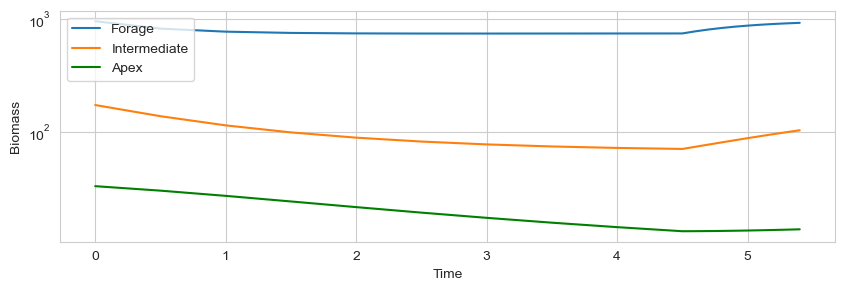

(<Figure size 1000x300 with 1 Axes>, <Axes: xlabel='Time', ylabel='Biomass'>)

In [17]:
expl_and_pause_times = torch.cat([expl_times, expl_times[-1] + pause_times])
expl_and_pause_biomass_at_times = torch.cat([expl_biomass_at_times, pause_biomass_at_times], dim=1)
plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times)

### Ecologically Aware Fishing

After a few years of exploitative fishing, ecological concerns begin to take more prominence. Our task is to take a high level understanding of fishery parameters (our "prior") and combine that with observed data during the exploitative period. We then seek a new set of fishing rates that also optimize for biodiversity and avoid rare, but catostrophic extinction events.  

#### Prior Definition
TODO port over details from julia file.

In [18]:
# Define prior over parameters of fishery.
# These are set ad-hoc so that the mean is approximately the true value.
# TODO Use now-available helper function lognormal_parameters to compute these directly. 
loc_scale_for_prior = OrderedDict(
    k1=dict(loc=6.94, scale=0.18),
    r1=dict(loc=0.76, scale=0.59),
    r2=dict(loc=0.0, scale=0.42),
    r3=dict(loc=-1.3, scale=0.79),
    p12=dict(loc=-0.70, scale=1.1),
    p23=dict(loc=-0.70, scale=1.1),
    d1=dict(loc=4.61, scale=0.42),
    d2=dict(loc=2.30, scale=0.42),
    e12=dict(loc=-1.97, scale=0.37),
    e23=dict(loc=-1.97, scale=0.37),
    m3=dict(loc=-4.232, scale=0.6)
)
def prior():
    od = OrderedDict()
    
    for k, v in loc_scale_for_prior.items():
        od[k] = pyro.sample(k, dist.LogNormal(**v))
    
    return od

In [19]:
# Plot the marginals for each parameter, alongisde the approximate lower and upper bounds, and the median.
def plot_marginals(samples, truevals=None):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, (name, samples_one_var) in enumerate(samples.items()):
        ax = axs[i // 4, i % 4]
        sns.kdeplot(samples_one_var, ax=ax)
        ax.axvline(torch.median(samples_one_var), color="r", linestyle="--", linewidth=0.1)
        sq = torch.quantile(samples_one_var, 0.025)
        ax.axvline(sq, color="r", linestyle="--", linewidth=0.3)
        lq = torch.quantile(samples_one_var, 0.975)
        ax.axvline(lq, color="r", linestyle="--", linewidth=0.3)
        ax.set_title(name)
        ax.grid(False)
        if truevals is not None:
            ax.axvline(truevals[name], color="k", linestyle="--")
        ax.set_xlim(0.0, lq*1.5)
    plt.tight_layout()
    return fig, axs

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

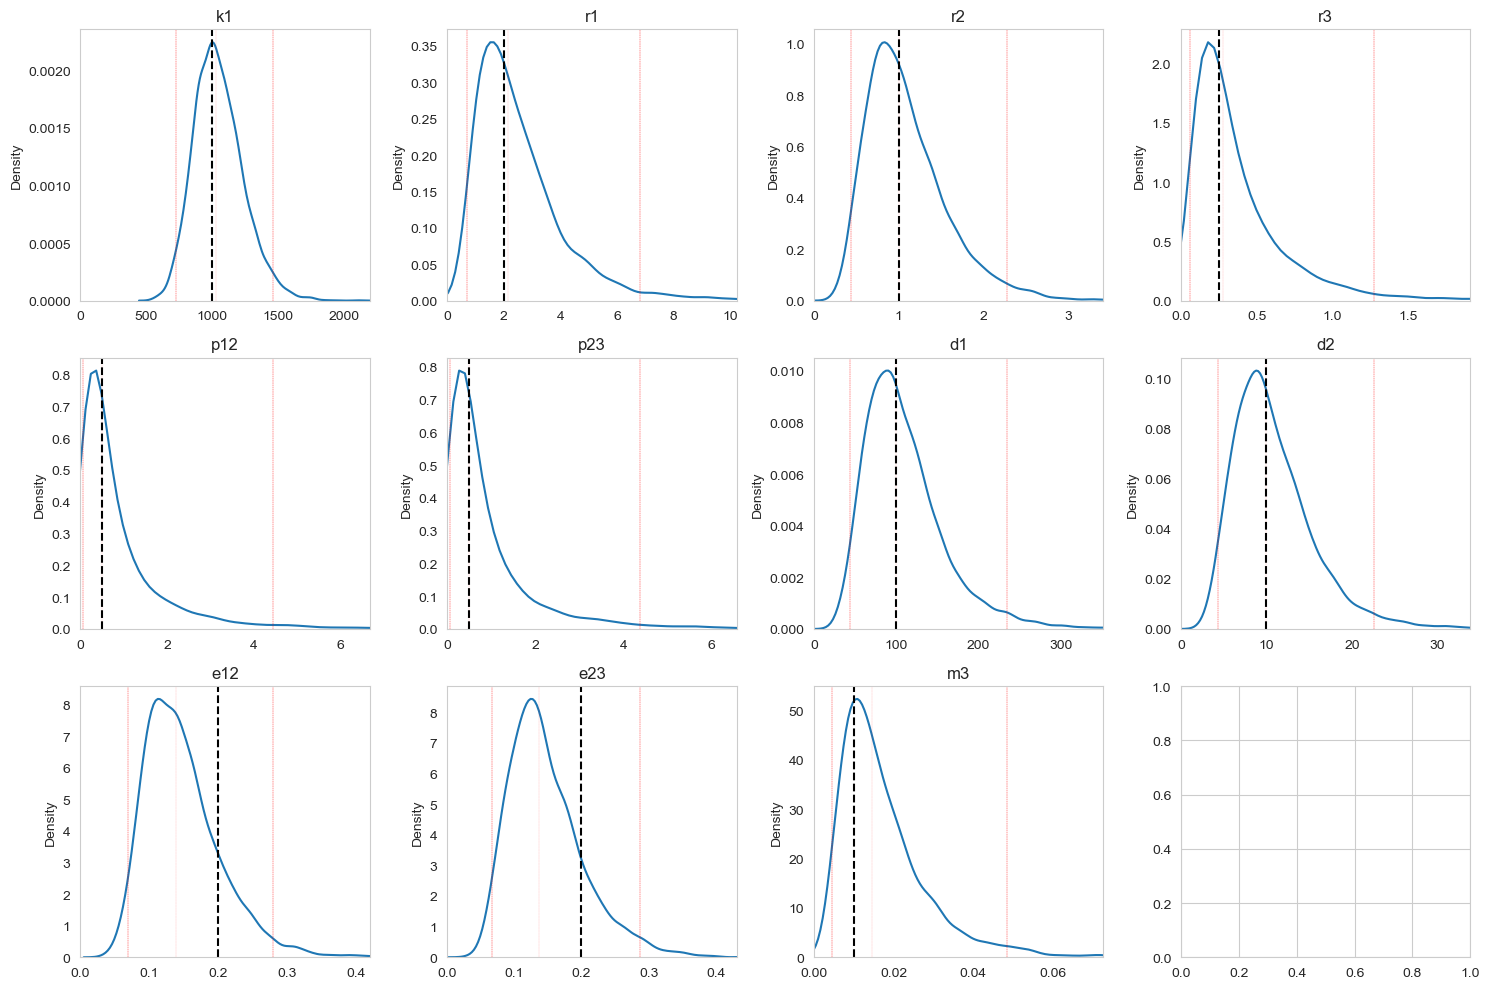

In [20]:
# Sample from the prior
with pyro.plate("samples", 5000):
    plot_marginals(prior(), TRUEVALS)
plt.show()

#### Observation Noise
Realistically, biomass measurements are noisy. We posit a simple roughly 20% relative error in biomass measurements for each trophic level. In reality, of course, this might differ across strata. 

In [21]:
def lognormal_parameters(mu, sigma):
    sigma_log = torch.log(sigma ** 2. / mu ** 2. + 1.0)
    mu_log = torch.log(mu) - 0.5 * sigma_log
    return mu_log, sigma_log

def observation_model(biomass_at_times, obs_str="obs"):
    # Use lognormals just to fold in the positivity constraints.
    unscaled_noise = 0.5
    sigma = (biomass_at_times ** 0.9) * unscaled_noise
    
    mu_log, sigma_log = lognormal_parameters(biomass_at_times, sigma)
    
    return pyro.sample(obs_str, dist.LogNormal(mu_log, sigma_log).to_event(mu_log.ndim))

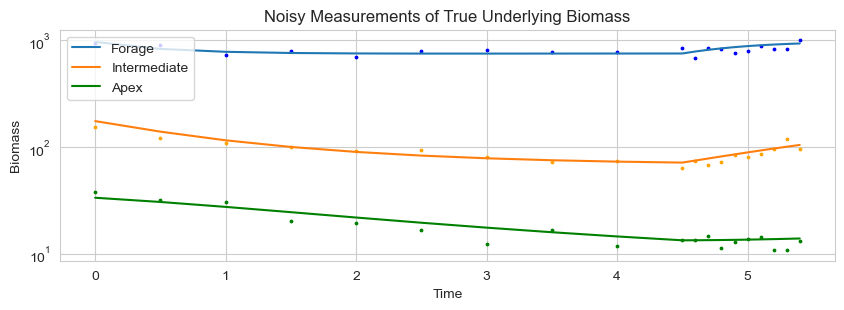

In [22]:
fig, ax = plot_biomass_over_time(expl_and_pause_times, expl_and_pause_biomass_at_times, show=False)

# Plot biomass measurement points.
observed_biomass_at_times = observation_model(expl_and_pause_biomass_at_times)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)
ax.set_title("Noisy Measurements of True Underlying Biomass")
plt.show()

#### Stiching the Model Together
Thus far we've defined a prior, two fishing regimes, and an observation model. We can now stitch these together into a full model. We additionally add prior uncertainty over the initial biomass.

In [23]:
# Add the biomass prior log normal parameters to the dict.
biomass0_mu_log, biomass0_sigma_log = lognormal_parameters(B_UNFISHED, 0.5 * B_UNFISHED)
loc_scale_for_biomass_prior = dict(loc=biomass0_mu_log, scale=biomass0_sigma_log)
def prior_initial_biomass():
    return pyro.sample("initial_biomass", dist.LogNormal(**loc_scale_for_biomass_prior).to_event(1))

def prior_predictive_fishery_model():
    parameters = prior()
    biomass0 = prior_initial_biomass()
    
    # Exploitative period.
    expl_x = flatten_for_temporal(parameters, biomass0, msr_rates, expl_times)
    expl_mean_y = fishery_temporal_solver(expl_x)
    
    # Pause period.
    pause_x = flatten_for_temporal(parameters, expl_mean_y[:, -1], torch.zeros_like(msr_rates), pause_times)
    pause_mean_y = fishery_temporal_solver(pause_x)
    
    return expl_mean_y, pause_mean_y, parameters, biomass0
    
def full_observed_fishery_model():
    expl_mean_y, pause_mean_y, parameters, biomass0 = prior_predictive_fishery_model()
    
    expl_obs_y = observation_model(expl_mean_y, "expl_obs")
    pause_obs_y = observation_model(pause_mean_y, "pause_obs")
    
    return expl_obs_y, pause_obs_y, expl_mean_y, pause_mean_y, parameters, biomass0

In [24]:
# DEBUG
prior_initial_biomass()


tensor([667.7835, 100.7307,  33.9285], dtype=torch.float64)

#### Visualize Prior Predictive

In [25]:
# Visualize the full model. It should look roughly like what we've plotted above.
obs_expl_biomass_at_times_list, obs_pause_biomass_at_times_list = [], []
mean_expl_biomass_at_times_list, mean_pause_biomass_at_times_list = [], []
for _ in range(1000):
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = full_observed_fishery_model()
    obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times)
    obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times)
    mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times)
    mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times)

obs_expl_biomass_at_times = torch.stack(obs_expl_biomass_at_times_list)
obs_pause_biomass_at_times = torch.stack(obs_pause_biomass_at_times_list)
mean_expl_biomass_at_times = torch.stack(mean_expl_biomass_at_times_list)
mean_pause_biomass_at_times = torch.stack(mean_pause_biomass_at_times_list)

In [26]:
obs_expl_and_pause_biomass_at_times = torch.cat([obs_expl_biomass_at_times, obs_pause_biomass_at_times], dim=-1)
mean_expl_and_pause_biomass_at_times = torch.cat([mean_expl_biomass_at_times, mean_pause_biomass_at_times], dim=-1)

# Get 0.05, 0.5, and 0.95 quantiles for each time point, so we can plot CIs.
obs_expl_and_pause_biomass_at_times_q = torch.quantile(obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
mean_expl_and_pause_biomass_at_times_q = torch.quantile(mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)


In [27]:
def plot_biomass_over_time_with_ci(times, biomass_at_times_q, logscale=True, show=True):
    fig, ax = plot_biomass_over_time(times, biomass_at_times_q[1], logscale, False)
    for i in range(3):
        ax.fill_between(times, biomass_at_times_q[0, i], biomass_at_times_q[2, i], alpha=0.3)
    if show:
        plt.show()
    return fig, ax

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass')

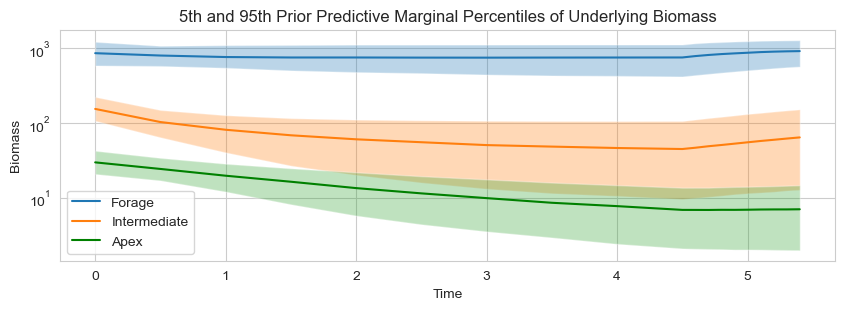

In [28]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, mean_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Underlying Biomass")

Text(0.5, 1.0, '5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements')

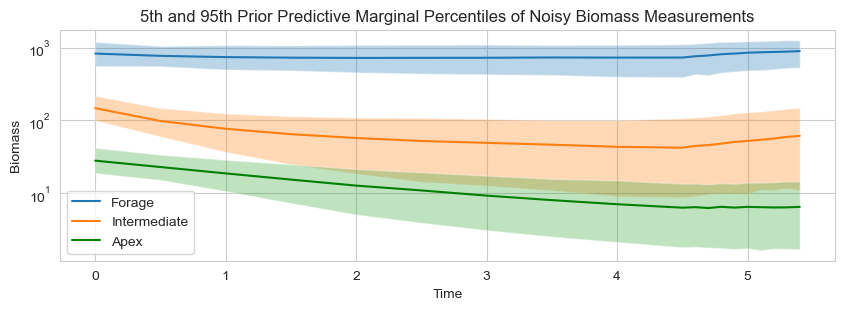

In [29]:
_, ax_ = plot_biomass_over_time_with_ci(expl_and_pause_times, obs_expl_and_pause_biomass_at_times_q, show=False)
ax_.set_title("5th and 95th Prior Predictive Marginal Percentiles of Noisy Biomass Measurements")

#### Multi-Objective
After a period of exploitative fishing, policy makers now wish to incorporate ecological objectives. This is formalized as a mult-objective involving a "disturbance index" (Bundy et al. 2005, Zhou and Smith, 2017) that measures the degree of disturbance to the trophic structure relative to the unfished equilibrium state — this acts as a measure of biodiversity. The disturbance index, however, doesn't adequately reflect the  unrecoverable nature of extinction events, so we additionally include a large penalty for cases where the equilibrium state of any trophic level reaches extinction.

In [30]:
def disturbance_index(fished_biomass, unfished_biomass):
    di = 0.0
    for i in range(2):
        di += torch.abs(
            (fished_biomass[i+1] / fished_biomass[i]) - (unfished_biomass[i+1] / unfished_biomass[i])
        )
    return di

def discrete_kl_divergence(p, q):
    return (p * (torch.log(p) - torch.log(q))).sum()
    

def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (discrete_kl_divergence(p, m) + discrete_kl_divergence(q, m))

def js_distance(p, q):
    return torch.sqrt(js_divergence(p, q))

def js_disturbance_index(fished_biomass, unfished_biomas):
    # To prevent log(0) issues and instability in proportions when everything goes extinct.
    p = fished_biomass + B_UNFISHED * 1e-2
    q = unfished_biomas + B_UNFISHED * 1e-2
    return js_distance(
        p / p.sum(),
        q / q.sum()
    )

def extinction_event(fished_biomass, unfished_biomass, relaxation=100, threshold=0.05):
    relative_biomass = torch.min(fished_biomass / (unfished_biomass + 1e-6))
    return 1. / (1. + torch.exp(relaxation * (relative_biomass - threshold)))
    

In [31]:
# These different objectives operate on different scales, so we'll need to scale them to be comparable.
 
unfished_ = fishery_steady_state(
    parameters=TRUEVALS,
    initial_biomass=B_UNFISHED,
    fishing_mortality_rates=torch.tensor([0.0, 0.0, 0.0]).double()
)

fisheds = []
mortalities = []

for growth_proportion in range(100):
    mortality = APPROX_GROWTH_RATES * (growth_proportion/100.)
    fished_ = fishery_steady_state(
        parameters=TRUEVALS,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=mortality
    )
    fisheds.append(fished_)
    mortalities.append(mortality)

disturbances = torch.stack([disturbance_index(fished, unfished_) for fished in fisheds])
js_disturbances = torch.stack([js_disturbance_index(fished, unfished_) for fished in fisheds])
extinctions = torch.stack([extinction_event(fished, unfished_) for fished in fisheds])
revenues = torch.stack([gross_revenue(
    biomass=fished,
    mortality=mortality,
    prices=PRICES
) for fished, mortality in zip(fisheds, mortalities)])

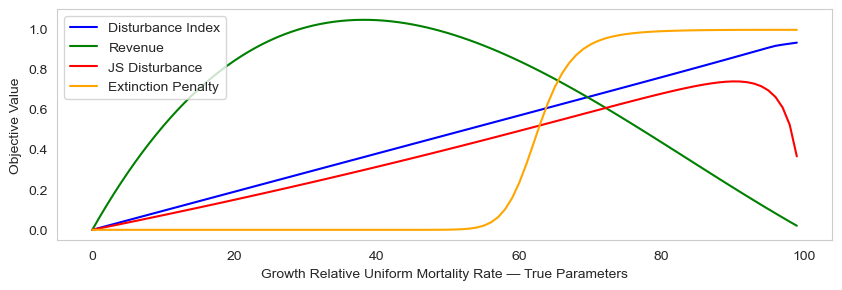

In [32]:
def scale_revenue(revenue):
    return revenue / 1000.0

def scale_disturbance(disturbance):
    return disturbance / 0.4

def scale_js_disturbance(js_disturbance):
    return js_disturbance / .23

def scale_extinction(extinction):
    return extinction

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(scale_disturbance(disturbances), label="Disturbance Index", color="b")
ax.plot(scale_revenue(revenues), label="Revenue", color="g")
ax.plot(scale_js_disturbance(js_disturbances), label="JS Disturbance", color="r")
ax.plot(scale_extinction(extinctions), label="Extinction Penalty", color="orange")

ax.set_xlabel("Growth Relative Uniform Mortality Rate — True Parameters")
ax.set_ylabel("Objective Value")
ax.legend()
ax.grid(False)

### TABDM
TABDM folds inference, prediction, and decision-making together. We'll use it to combine our prior with observed data to prescribe fishing rates that optimize a joint objective. Before, fishery regulators were only interested in maximum sustainable revenue. This led to concerning declines in apex predator numbers. Now, we want to ensure the fishing rates also support biodiversity and avoid rare (low probability), but catastrophic extinction events.

In [33]:
def normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates, return_fuf=False):
    fishing_mortality_rates = torch.abs(fishing_mortality_rates)
    
    fished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=initial_biomass,
        fishing_mortality_rates=fishing_mortality_rates
    )
    
    unfished = fishery_steady_state(
        parameters=parameters,
        initial_biomass=B_UNFISHED,
        fishing_mortality_rates=torch.zeros_like(fishing_mortality_rates)
    )
    
    revenue = scale_revenue(gross_revenue(fished, fishing_mortality_rates, PRICES))
    # disturbance = scale_js_disturbance(js_disturbance_index(fished, unfished))
    # TODO HACK because its unstable and breaks stuff, but we still need it to be gradable for params.
    disturbance = fishing_mortality_rates.sum()
    extinction = scale_extinction(extinction_event(fished, unfished))
    
    if torch.any(fished < 0):
        print("fished < 0", fished.detach().numpy())
        
    if torch.any(unfished < 0):
        print("unfished < 0", unfished.detach().numpy())
    
    if not torch.isfinite(revenue) or revenue < 0:
        print("revenue?", revenue, fished.detach().numpy(), unfished.detach().numpy())
    
    if not torch.isfinite(disturbance) or disturbance < 0:
        print("disturbance?", disturbance, fished.detach().numpy(), unfished.detach().numpy())
        
    if not torch.isfinite(extinction) or extinction < 0:
        print("extinction?", extinction, fished.detach().numpy(), unfished.detach().numpy())
        
    ret = OrderedDict(
            revenue=revenue,
            disturbance=disturbance,
            extinction=extinction
        )
    if return_fuf:
        return ret, fished, unfished
    else:
        return ret

#### Sensitivity Analysis
... This provides intuition about where the objectives are large with respect regions of uncertainty.

In [34]:
n = 300
multiobjective_samples = OrderedDict(
    revenue=torch.zeros(n),
    disturbance=torch.zeros(n),
    extinction=torch.zeros(n)
)
multiobjective_gradient_samples = OrderedDict(
    revenue=torch.zeros(n, NUM_SPECIES),
    disturbance=torch.zeros(n, NUM_SPECIES),
    extinction=torch.zeros(n, NUM_SPECIES)
)
fishery_policy_params_sa = (APPROX_GROWTH_RATES.clone() * 0.3).requires_grad_()
# TODO vectorize.
for i in range(n):
    multiobjective_sample, fished, unfished = normalized_multiobjective(
        prior(),
        pause_biomass_at_times[:, -1],
        fishery_policy_params_sa,
        return_fuf=True
    )
    
    for k, v in multiobjective_sample.items():
        multiobjective_samples[k][i] = v.detach()
    
    revenue_gradients = torch.autograd.grad(
        outputs=multiobjective_sample["revenue"],
        inputs=fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    disturbance_gradients = torch.autograd.grad(
        multiobjective_sample["disturbance"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    extinction_gradients = torch.autograd.grad(
        multiobjective_sample["extinction"],
        fishery_policy_params_sa,
        retain_graph=True
    )[0]
    
    # If any gradients are non-finite, identify which one and print out the multi objective
    #  values.
    if not torch.isfinite(revenue_gradients).all():
        print("revenue grad nonfinite", multiobjective_sample)
    if not torch.isfinite(disturbance_gradients).all():
        print("disturbance grad nonfinite", multiobjective_sample)
    if not torch.isfinite(extinction_gradients).all():
        print("extinction grad nonfinite", multiobjective_sample)
    
    if (torch.abs(disturbance_gradients) > 30).any():
        # So the disturbance gradient becomes very large and kind of random when everything goes extinct.
        # The intuition is that tiny changes in fishing pressure in this regime will cause massive changes
        #  to the relative biomass between species (and is probably dominated by solver instability anyway).
        print("-----------------")
        print("disturbance grad large")
        print("fished", fished.detach().numpy())
        print("unfished", unfished.detach().numpy())
        print("disturbance", multiobjective_sample["disturbance"])
        print("gradient", disturbance_gradients.detach().numpy())
        print("-----------------")
    
    for k, v in multiobjective_gradient_samples.items():
        v[i, :] = locals()[f"{k}_gradients"].detach()

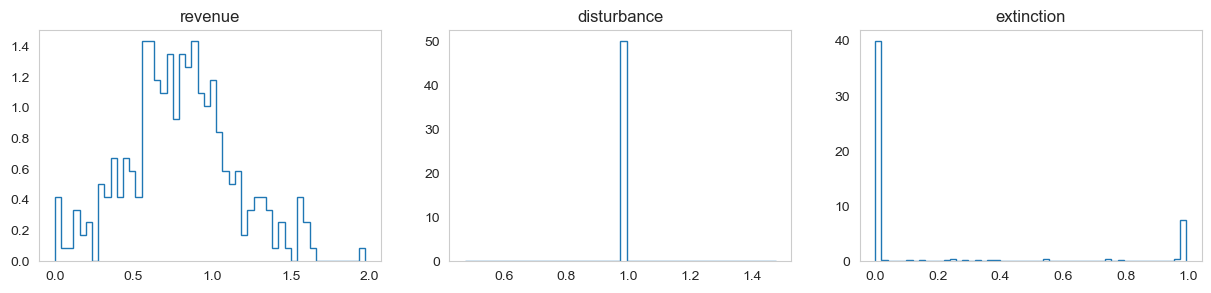

In [35]:
# First, plot the marginals of the objectives.
_, axs = plt.subplots(1, 3, figsize=(15, 3))
for i, (name, samples_one_var) in enumerate(multiobjective_samples.items()):
    ax = axs[i]
    ax.grid(False)
    # sns.kdeplot(samples_one_var, ax=ax)
    ax.hist(samples_one_var, bins=50, histtype="step", density=True)
    ax.set_title(name)

------revenue-------
------Species 0-------
Mean tensor(0.0601)
QL tensor(-0.3109)
QM tensor(0.1784)
QH tensor(0.5125)
Max tensor(1.0775)
Min tensor(-1.8783)
%Finite tensor(1.)
------Species 1-------
Mean tensor(0.5671)
QL tensor(0.0930)
QM tensor(0.5532)
QH tensor(1.0922)
Max tensor(3.0541)
Min tensor(-1.2744)
%Finite tensor(1.)
------Species 2-------
Mean tensor(0.4969)
QL tensor(3.4274e-08)
QM tensor(0.3724)
QH tensor(0.8154)
Max tensor(10.1354)
Min tensor(-0.8752)
%Finite tensor(1.)
------disturbance-------
------Species 0-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------Species 1-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------Species 2-------
Mean tensor(1.)
QL tensor(1.)
QM tensor(1.)
QH tensor(1.)
Max tensor(1.)
Min tensor(1.)
%Finite tensor(1.)
------extinction-------
------Species 0-------
Mean tensor(0.2102)
QL tensor(1.2787e-16)
QM t

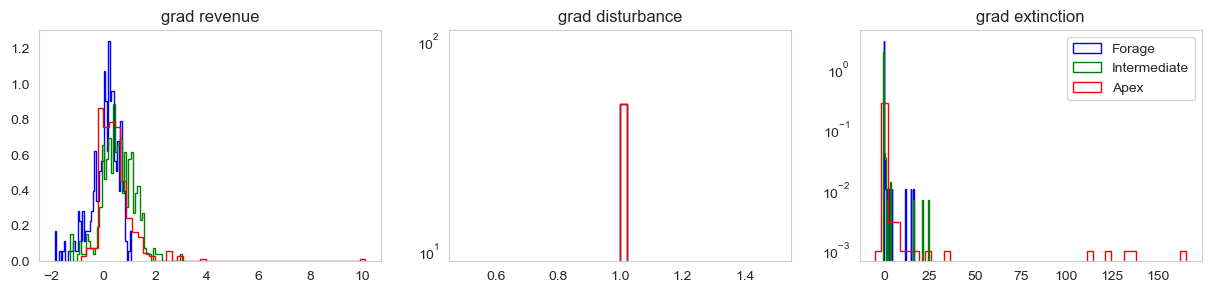

In [36]:
# Now plot the three partials for each component objective in a similar subplot arrangement, but with three lines plotted in each subplot
_, axs = plt.subplots(1, 3, figsize=(15, 3))
colors = ["b", "g", "r"]
labels = ["Forage", "Intermediate", "Apex"]
for i, (name, gradient_samples_one_var) in enumerate(multiobjective_gradient_samples.items()):
    ax = axs[i]
    ax.grid(False)
    print(f"------{name}-------")
    for j in range(NUM_SPECIES):
        # sns.kdeplot(gradient_samples_one_var[:, j], ax=ax, gridsize=1000)
        # hist without filling.
        ax.hist(gradient_samples_one_var[:, j], bins=50, histtype="step", density=True,
                label=labels[j], color=colors[j])
        print(f"------Species {j}-------")
        print("Mean", gradient_samples_one_var[:, j].mean())
        print("QL", gradient_samples_one_var[:, j].quantile(0.2))
        print("QM", gradient_samples_one_var[:, j].quantile(0.5))
        print("QH", gradient_samples_one_var[:, j].quantile(0.8))
        print("Max", gradient_samples_one_var[:, j].max())
        print("Min", gradient_samples_one_var[:, j].min())
        print("%Finite", torch.isfinite(gradient_samples_one_var[:, j]).float().mean())
    ax.set_title(f"grad {name}")

# axs[0].set_xlim(-3, 3)
# axs[1].set_xlim(-1, 2)
# axs[2].set_xlim(-10, 10)
axs[1].set_yscale("log")
axs[2].set_yscale("log")
axs[2].legend()

#### TABDM Decomposition
In our setting, the optimal proposals for revenue and the disturbance index are slightly skewed, but not particularly heavy-tailed. The extinction penalty, however, shows a small mode in the tails around catostrophic extinctions, and is likely to benefit from target aware approaches. Thus, while we employ the TABI decomposition for revenue and disturbance to debias them, we simply use the posterior approximation as the proposal for all components.

For the extinction event, however, we employ both the full- and single-TABDM approaches with both mixtures of gaussians and expressive normalizing flows. These are further compared to the biased and untargeted monte-carlo approach using a posterior approximation, and PAIS, which does utilize vanilla importance sampling to target the extinction event by incorrectly assuming the posterior approximation is true.

We show weighted, high-sample estimates of the multi-objective at a few checkpoints in the optimization process.

In [37]:
# # Aspects of the multi-objective that aren't tail-heavy.
# def build_rescaled_revenue_and_disturbance_f(fishing_mortality_rates, objective_scaling_dict):
#     def rescaled_revenue_and_disturbance_f(stochastics):
#         initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
#         parameters = stochastics
#         multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
#         
#         rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
#         rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
#         
#         return rescaled_revenue - rescaled_disturbance
#     
#     return rescaled_revenue_and_disturbance_f
# 
# # Aspect of the multi-objective that is tail-heavy.
# def build_rescaled_extinction_f(fishing_mortality_rates, objective_scaling_dict):
#     def rescaled_extinction_f(stochastics):
#         initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
#         parameters = stochastics
#         multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
#         
#         rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
#         
#         return -rescaled_extinction
#     return rescaled_extinction_f

from copy import copy
from typing import Dict, Optional, Callable

ObjFnType = Callable[[OrderedDict[str, torch.Tensor], torch.Tensor], torch.Tensor]
StochType = OrderedDict[str, torch.Tensor]

# Just the full multiobjective.
def build_full_rescaled_multiobjective_f(
        objective_scaling_dict: Dict,
        return_vec=False
) -> ObjFnType:
    def full_rescaled_multiobjective_f(
            stochastics: StochType,
            fishing_mortality_rates: torch.Tensor
    ):  
        stochastics = copy(stochastics)
        initial_biomass = stochastics.pop("initial_biomass")  # TODO HACK 2801gdl clean this up
        parameters = stochastics
        multiobjective = normalized_multiobjective(parameters, initial_biomass, fishing_mortality_rates)
        
        rescaled_revenue = multiobjective["revenue"] * objective_scaling_dict["revenue"]
        rescaled_disturbance = multiobjective["disturbance"] * objective_scaling_dict["disturbance"]
        rescaled_extinction = multiobjective["extinction"] * objective_scaling_dict["extinction"]
        
        if not return_vec:
            return rescaled_revenue - rescaled_disturbance - rescaled_extinction
        else:
            return torch.cat([rescaled_revenue[None], -rescaled_disturbance[None], -rescaled_extinction[None]])
        
    return full_rescaled_multiobjective_f


def build_jac(obj_fn: ObjFnType):
    def compute_jac(stochastics: StochType, fishing_mortality_rates: torch.Tensor):
        
        def policy_param_closure(fmr):
            return obj_fn(stochastics, fmr)
        
        # Must create_graph=True so that the ELBO can be pushed back through this via a log factor in pseudens.
        jac = torch.autograd.functional.jacobian(
            policy_param_closure,
            fishing_mortality_rates,
            create_graph=True,
            strict=True
        )
        
        return jac
    
    return compute_jac

In [38]:
# # DEBUG
# stochs = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}
# 
# fpp = msr_rates.detach().clone().requires_grad_()
# 
# frmo = build_full_rescaled_multiobjective_f(
#     dict(revenue=1.0, disturbance=1.0, extinction=10.0),
#     return_vec=False
# )
# 
# frmo_jac = build_jac(frmo)
# print(frmo_jac(stochs, fpp))
# 
# print()
# 
# frmo_vec = build_full_rescaled_multiobjective_f(
#     dict(revenue=1.0, disturbance=1.0, extinction=10.0),
#     return_vec=True
# )
# 
# frmo_jac_vec = build_jac(frmo_vec)
# full_jac = frmo_jac_vec(stochs, fpp)
# print(full_jac)
# print(full_jac.sum(axis=0))  # sum over rows (outputs) to get grads for columns (inputs)
# 
# # Grad check fishing params without stochs.
# torch.autograd.gradcheck(lambda x: frmo(stochs, x), (fpp,))
# print("Passed fpp gradcheck.")
# 
# # Do a grad check of stochastics, not fishing policy params, through the jacobian function.
# def gradcheck_fn_wrt_stochs(fn):
#     for k, v in stochs.items():
#         v.requires_grad_()
#         _ = (lambda x: fn(stochs | {k: x}, fpp))(v)  # runtime check of closure.
#         torch.autograd.gradcheck(lambda x: fn(stochs | {k: x}, fpp), (v,))
#         
#         
# # Dummy test.
# def dummy_fn(s, p):
#     ret = 0.0
#     for k, v in s.items():
#         ret += v.sum() ** 2.
#     return ret + p.sum() ** 2.
# 
# dummy_fn_jac = build_jac(dummy_fn)
# gradcheck_fn_wrt_stochs(dummy_fn)
# gradcheck_fn_wrt_stochs(dummy_fn_jac)
# print("Passed dummy_fn stochs gradcheck.")
# 
# gradcheck_fn_wrt_stochs(frmo)
# print("Passed frmo stochs gradcheck.")
# gradcheck_fn_wrt_stochs(frmo_vec)
# print("Passed frmo_vec stochs gradcheck.")
# gradcheck_fn_wrt_stochs(frmo_jac)
# print("Passed frmo_jac stochs gradcheck.")
# gradcheck_fn_wrt_stochs(frmo_jac_vec)
# 
# # FIXME WIP jac gradchecks don't pass.

In [39]:
def build_fit_variational_approximation(pseudo_density, guide, lr):
    elbo = pyro.infer.Trace_ELBO()(pseudo_density, guide)
    elbo()
    optim = torch.optim.Adam(elbo.parameters(), lr=lr)
    
    def fit_variational_approximation():
        for _ in range(5): # 5 retries
            for param in elbo.parameters():
                param.grad = None
            optim.zero_grad()
            
            try:
                loss = elbo()
                loss.backward()
            # This can be biased. In our setting, it generally won't be though because 
            #  the system is stable around likely parameters.
            except JuliaError:
                print("Failed pseudo density solve, retrying...this may result in bias.")
                continue
                
            try:
                torch.nn.utils.clip_grad_norm_(elbo.parameters(), 50000.0, error_if_nonfinite=True)
            except RuntimeError as e:
                if "is non-finite" in str(e):
                    print("Non-finite gradient, retrying...this may result in bias.")
                    continue
                else:
                    raise
                    
            optim.step()
            break
    
    return fit_variational_approximation

In [40]:
def build_step_policy_param(fishing_mortality_rates, lr, clip):
    optim = torch.optim.SGD((fishing_mortality_rates,), lr=lr)
    one = torch.tensor(1.).double()
    
    def step_policy_param(grad_estimate):
        optim.zero_grad()
        fishing_mortality_rates.grad = None
        
        clipped_grad_estimate = grad_estimate * torch.min(one, clip / torch.linalg.norm(grad_estimate))
        
        # The SGD stuff assumes this is a loss, but it's actually an objective, so go the other way to negate the negation.
        fishing_mortality_rates.grad = -clipped_grad_estimate
        
        optim.step()
    
    return step_policy_param

In [41]:
conditioned_model = pyro.condition(full_observed_fishery_model, data=dict(
    expl_obs=observed_biomass_at_times[:, :len(expl_times)], pause_obs=observed_biomass_at_times[:, len(expl_times):]
))

In [42]:
OBJECTIVE_SCALING_DICT = dict(
    revenue=1.0,
    disturbance=0.0,  # ignoring this for simplicity.
    extinction=10.0,
)

In [43]:
# # DEBUG !! OUTDATED AFTER build_full_rescaled_multiobjective_f sig change !!
# from copy import copy
# # Grad check the full multiobjective wrt the fishing mortality rates.
# fishing_policy_params = msr_rates.detach().clone().requires_grad_()
# # multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, OBJECTIVE_SCALING_DICT)
# STOCHASTICS = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}
# # multiobj_val = multiobjective(stochastics)
# 
# # Use standard grad check of fishing_policy_params and multiobj_val.
# torch.autograd.gradcheck(lambda fpp: build_full_rescaled_multiobjective_f(fpp, OBJECTIVE_SCALING_DICT)(copy(STOCHASTICS)), (fishing_policy_params,))
# 
# # DEBUG
# fishing_policy_params = msr_rates.detach().clone().requires_grad_()
# multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, OBJECTIVE_SCALING_DICT)
# multiobjective_grad, multiobjective_val = build_jac(fishing_policy_params, multiobjective)
# multiobjective_grad(copy(STOCHASTICS))

In [44]:
# # TESTS !! OUTDATED AFTER build_full_rescaled_multiobjective_f sig change !!
# from copy import copy
# 
# 
# # Test that the full rescaled multiobjective is behaving as expected. Do so by checking grads and values for true values of RVs under different scalings.
# def test_multiobjective():
#     
#     TRUE_STOCHS = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}
#     
#     def test_disturbance_only():
#         # No fishing...
#         fishing_policy_params = torch.zeros_like(msr_rates).requires_grad_() + 0.23
#         
#         multiobjective = build_full_rescaled_multiobjective_f(fishing_policy_params, objective_scaling_dict={"revenue": 0.0, "disturbance": 0.0, "extinction": 1.0})
#         multiobjective_grad = build_jac(fishing_policy_params, multiobjective)
#         obj_grad, obj_val = multiobjective_grad(copy(TRUE_STOCHS))
#         
#         print(obj_grad, obj_val)
#         
#         # TODO...
# 
#     
#     test_disturbance_only()
#     
# test_multiobjective()

In [45]:
from chirho.contrib.compexp.utils import kft

# First, set up Posterior-Approximation Monte Carlo. This will simply update the posterior approximation, sample from it, and then push that through the model gradients.
def pamc(model, guide, svi_lr: float, fpo_lr: float, fpo_clip: float, burnin_iters: int, opt_iters: int, obj_scaling=None, debias=False):
    
    fit_posterior = build_fit_variational_approximation(
        pseudo_density=model,
        guide=guide,
        lr=svi_lr
    )
    
    obj_scaling = OBJECTIVE_SCALING_DICT if obj_scaling is None else obj_scaling
    
    fishing_policy_params = msr_rates.detach().clone().requires_grad_()
    multiobjective = build_full_rescaled_multiobjective_f(obj_scaling)
    multiobjective_grad = build_jac(multiobjective)
    step_policy_param = build_step_policy_param(fishing_policy_params, fpo_lr, fpo_clip)
    
    # DEBUG commented out
    for bi in range(burnin_iters):
        print(f"Burnin Iteration: {bi:05d}", end="\r")
        fit_posterior()
    print()
    
    yield fishing_policy_params.detach().clone()
    
    log_denom = 0.0
    
    for i in range(burnin_iters, burnin_iters + opt_iters):
        
        for _ in range(5):  # 5 attempts at a gradient estimate. FIXME bias is possible if anything beyond the first iter gets used.
            guide_trace = pyro.poutine.trace(guide).get_trace()
            
            logp_minus_logq = 0.0
            if debias:
                logq = guide_trace.log_prob_sum()
                logp = pyro.poutine.trace(pyro.poutine.replay(model, trace=guide_trace)).get_trace().log_prob_sum()
                logp_minus_logq = logp - logq
                # Track denominator (normalizing constant) across the entire optimization.
                log_denom += logp_minus_logq
                
            stochastics = kft(guide_trace)
            # DEBUG instead of above.
            # stochastics = {k: v.detach().clone() for k, v in TRUEVALS.items()}
            # stochastics["initial_biomass"] = B_UNFISHED.detach().clone()
            
            try:
                grad_estimate = multiobjective_grad(stochastics, fishing_policy_params)
                if not torch.isfinite(grad_estimate).all():
                    raise JuliaError(Exception())
            except JuliaError:
                print("Failed steady state solve, retrying...this may result in bias.")
                # print(stochastics)
                continue
            
            if debias:
                grad_estimate = grad_estimate * torch.exp(logp_minus_logq - log_denom / (i + 1))
            
            step_policy_param(grad_estimate)
            break
        
        yield fishing_policy_params.detach().clone()

In [46]:
from pyro.infer.autoguide.initialization import init_to_value
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import EasyGuide
from copy import copy
from pyro.nn.module import PyroModule, PyroParam


pamc_model = conditioned_model

def get_all_log_loc_scale():
    all_log_loc_scale_for_prior = copy(loc_scale_for_prior)
      # TODO HACK 2801gdl clean this up
    all_log_loc_scale_for_prior["initial_biomass"] = loc_scale_for_biomass_prior
    
    init_log_loc_flat = []
    init_log_scale_flat = []
    for k, v in all_log_loc_scale_for_prior.items():
        init_log_loc_flat.append(torch.tensor(v["loc"]).double().flatten())
        init_log_scale_flat.append(torch.tensor(v["scale"]).double().flatten())
    
    return torch.cat(init_log_loc_flat).detach().clone(), torch.cat(init_log_scale_flat).detach().clone()

# # <NF Attempt>
# # Bugs:
# #  [/]  parameters aren't being registered/found with pyro.module("flow", flow) 
# #  [ ]  maybe need to rescale priors to be [-5, 5]?
# def build_zuko_guide(model):
#     init_loc_flat = get_flat_true_params()
#     nparams = init_loc_flat.shape[0]
# 
#     flow = zuko.flows.NSF(features=nparams, context=0, transforms=1, hidden_features=(16, 16))
#     flow.transform = flow.transform.inv  # inverse autoregressive flow (IAF) are fast to sample from
# 
#     @easy_guide(model)
#     def zuko_guide(self):
#         # pyro.module("flow", flow)  # FIXME HACK hd62lglat not working to register parameters.
# 
#         # Match everything cz we're going to sample them as a joint normalizing flow.
#         group = self.group(match=".*")
# 
#         return group.sample("joint_nf", ZukoToPyro(flow()))[-1]  # [-1] is the dict of samples remapped from group.
# 
#     # FIXME HACK hd62lglat do it manually.
#     zuko_guide._parameters = dict(flow.named_parameters())
# 
#     return zuko_guide
# 
# pamc_guide = build_zuko_guide(pamc_model)
# # <NF Attempt>

# <Mixture of MV Normals>
class GMMGuide(EasyGuide):
    def __init__(self, init_loc, init_scale_vec, ncomponents: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.ncomponents = ncomponents
        
        self.locs = PyroParam(
            init_loc.repeat(self.ncomponents, 1).detach().clone(),
            constraint=dist.constraints.real
        )
        
        self.mixture_weights = PyroParam(
            (torch.ones(self.ncomponents) / self.ncomponents).detach().clone(),
            constraint=dist.constraints.simplex
        )
        
        self.scale_trils = PyroParam(
            torch.diag(init_scale_vec).unsqueeze(0).repeat(self.ncomponents, 1, 1).detach().clone(),
            constraint=dist.constraints.lower_cholesky
        )
        
    def guide(self):
        mixture_dist = dist.MixtureSameFamily(
            mixture_distribution=dist.Categorical(self.mixture_weights),
            component_distribution=dist.MultivariateNormal(
                loc=self.locs,
                scale_tril=self.scale_trils
            )
        )

        # Match everything, as they'll be sampled jointly from a single mixture same family.
        group = self.group(match=".*")

        ret = group.sample("joint_gmm", mixture_dist)

        return ret[-1]

prior_log_locs, prior_log_scales = get_all_log_loc_scale()

pamc_guide = GMMGuide(
    init_loc=prior_log_locs,
    init_scale_vec=prior_log_scales,
    ncomponents=1,
    model=pamc_model
)

# </Mixture of Log Normal Gaussians>

# pamc_guide = pyro.infer.autoguide.AutoMultivariateNormal(
#     pamc_model,
#     # TODO WIP need to figure out LogNormal parameters s.t. we can multiply up to proper scale for all params,
#     #  from e.g. unit scale. That way this single scale parameter will actually initialize decently.
#     init_scale=1.0,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )

# # DEBUG
# pamc_guide = pyro.infer.autoguide.AutoDelta(
#     pamc_model,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )

/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_98255/3038211798.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_log_loc_flat.append(torch.tensor(v["loc"]).double().flatten())
/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_98255/3038211798.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_log_scale_flat.append(torch.tensor(v["scale"]).double().flatten())


In [47]:
# DEBUG
pamc_guide()

{'k1': tensor(974.0200, dtype=torch.float64),
 'r1': tensor(4.3419, dtype=torch.float64),
 'r2': tensor(0.6308, dtype=torch.float64),
 'r3': tensor(0.1494, dtype=torch.float64),
 'p12': tensor(0.3558, dtype=torch.float64),
 'p23': tensor(0.4368, dtype=torch.float64),
 'd1': tensor(168.1654, dtype=torch.float64),
 'd2': tensor(8.1347, dtype=torch.float64),
 'e12': tensor(0.1814, dtype=torch.float64),
 'e23': tensor(0.1868, dtype=torch.float64),
 'm3': tensor(0.0374, dtype=torch.float64),
 'initial_biomass': tensor([729.7810, 146.6606,  27.9283], dtype=torch.float64)}

In [48]:
import time

pamc_start_t = time.time()
pamc_result = torch.stack([params for params in pamc(
    model=pamc_model,
    guide=pamc_guide,
    svi_lr=1e-3,
    fpo_lr=1e-3,
    fpo_clip=20.0,
    burnin_iters=5000,
    # burnin_iters=0,
    opt_iters=1000,
    debias=False
)])
print("pamc wall time", time.time() - pamc_start_t)

Burnin Iteration: 04999
pamc wall time 85.987220287323


In [49]:
# DEBUG
# {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()}

In [50]:
def plot_parameter_optimization(results):
    np_results = results.numpy().T
    _, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(np.abs(np_results[0]), label="Forage", color="b")
    ax.plot(np.abs(np_results[1]), label="Intermediate", color="g")
    ax.plot(np.abs(np_results[2]), label="Apex", color="r")
    
    for r in msr_rates:
        ax.axhline(r, color="k", linestyle="--")
    
    ax.legend()
    return ax

<Axes: >

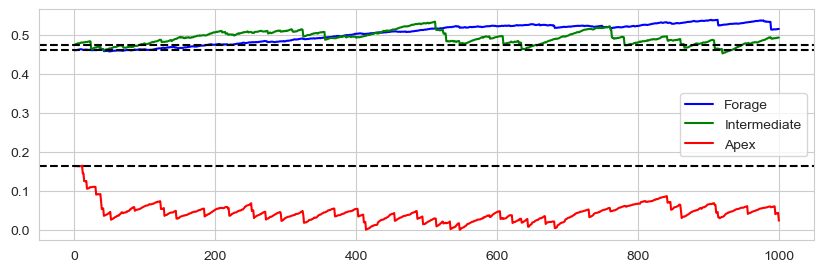

In [51]:
plot_parameter_optimization(pamc_result)

In [52]:
# TODO generate samples from the resultant posterior, just to sanity check that. Emulate prior marginal plots. This will require drawing from guide, probably kft-ing them, and stacking them together in a result?

# Start by generating samples from the guide, using keys from true vals.
n = 1000
pamc_posterior_samples = OrderedDict(
    {k: torch.zeros(n) for k in TRUEVALS.keys()}
)
traces = []

for i in range(n):
    guide_trace = pyro.poutine.trace(pamc_guide).get_trace()
    traces.append(guide_trace)
    stochastics = kft(guide_trace)
    
    for k, v in pamc_posterior_samples.items():
        pamc_posterior_samples[k][i] = stochastics[k].detach()

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

(<Figure size 1500x1000 with 12 Axes>,
 array([[<Axes: title={'center': 'k1'}, ylabel='Density'>,
         <Axes: title={'center': 'r1'}, ylabel='Density'>,
         <Axes: title={'center': 'r2'}, ylabel='Density'>,
         <Axes: title={'center': 'r3'}, ylabel='Density'>],
        [<Axes: title={'center': 'p12'}, ylabel='Density'>,
         <Axes: title={'center': 'p23'}, ylabel='Density'>,
         <Axes: title={'center': 'd1'}, ylabel='Density'>,
         <Axes: title={'center': 'd2'}, ylabel='Density'>],
        [<Axes: title={'center': 'e12'}, ylabel='Density'>,
         <Axes: title={'center': 'e23'}, ylabel='Density'>,
         <Axes: title={'center': 'm3'}, ylabel='Density'>, <Axes: >]],
       dtype=object))

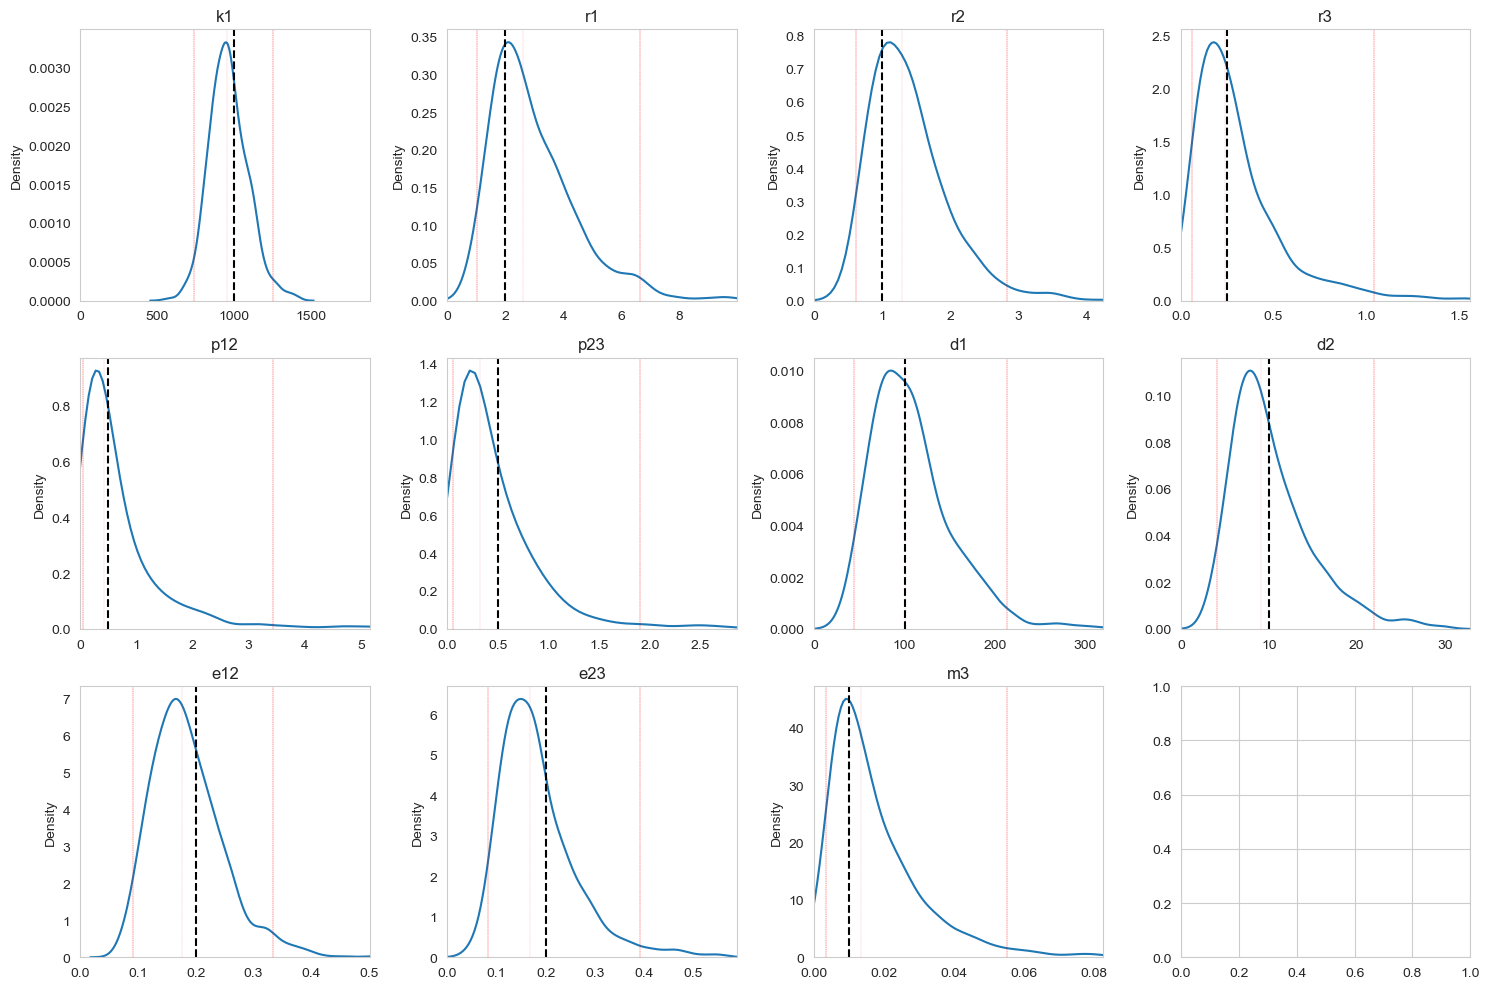

In [53]:
plot_marginals(pamc_posterior_samples, TRUEVALS)

In [54]:
# Plot posterior predictive.
pamc_obs_expl_biomass_at_times_list, pamc_obs_pause_biomass_at_times_list = [], []
pamc_mean_expl_biomass_at_times_list, pamc_mean_pause_biomass_at_times_list = [], []
# Use replay to play the guide trace through the fully observed temporal model.
for trace in traces:
    res = pyro.poutine.replay(full_observed_fishery_model, trace)()
    obs_expl_biomass_at_times, obs_pause_biomass_at_times, mean_expl_biomass_at_times, mean_pause_biomass_at_times, _, _ = res
    
    pamc_obs_expl_biomass_at_times_list.append(obs_expl_biomass_at_times.detach())
    pamc_obs_pause_biomass_at_times_list.append(obs_pause_biomass_at_times.detach())
    pamc_mean_expl_biomass_at_times_list.append(mean_expl_biomass_at_times.detach())
    pamc_mean_pause_biomass_at_times_list.append(mean_pause_biomass_at_times.detach())
    
pamc_obs_expl_biomass_at_times = torch.stack(pamc_obs_expl_biomass_at_times_list)
pamc_obs_pause_biomass_at_times = torch.stack(pamc_obs_pause_biomass_at_times_list)
pamc_mean_expl_biomass_at_times = torch.stack(pamc_mean_expl_biomass_at_times_list)
pamc_mean_pause_biomass_at_times = torch.stack(pamc_mean_pause_biomass_at_times_list)

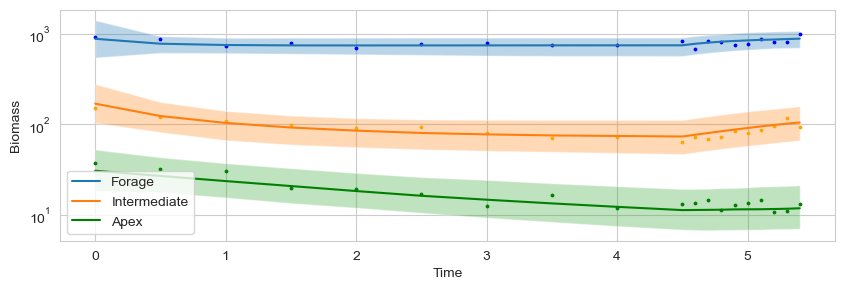

In [55]:
# Plot the posterior predictive.
pamc_obs_expl_and_pause_biomass_at_times = torch.cat([pamc_obs_expl_biomass_at_times, pamc_obs_pause_biomass_at_times], dim=-1).detach()
pamc_mean_expl_and_pause_biomass_at_times = torch.cat([pamc_mean_expl_biomass_at_times, pamc_mean_pause_biomass_at_times], dim=-1).detach()

pamc_obs_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_obs_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)
pamc_mean_expl_and_pause_biomass_at_times_q = torch.quantile(pamc_mean_expl_and_pause_biomass_at_times, torch.tensor([0.05, 0.5, 0.95]).double(), dim=0)

_, ax = plot_biomass_over_time_with_ci(expl_and_pause_times, pamc_mean_expl_and_pause_biomass_at_times_q, show=False)

# And plot the original data with a scatter. The stuff that's being conditioned on in the model.
ax.scatter(expl_and_pause_times, observed_biomass_at_times[0], color="b", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[1], color="orange", s=3.)
ax.scatter(expl_and_pause_times, observed_biomass_at_times[2], color="g", s=3.)

In [56]:
# # DEBUG
# # AutoDelta Guide
# true_delta_guide = pyro.infer.autoguide.AutoDelta(
#     pamc_model,
#     init_loc_fn=init_to_value(values={k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()})
# )
# 
# pamc_msr_result = torch.stack([params for params in pamc(
#     model=pamc_model,
#     # guide=pamc_guide,
#     guide=true_delta_guide,  # DEBUG instead of above.
#     svi_lr=1e-3,
#     fpo_lr=1e-3,
#     fpo_clip=30.0,
#     burnin_iters=0,
#     opt_iters=500,
#     obj_scaling=dict(
#         revenue=0.0,
#         disturbance=1.0,
#         extinction=0.0,
#     ),
#     # debias=False
# )])

In [57]:
# # DEBUG
# ax = plot_parameter_optimization(pamc_msr_result)
# # print(msr_rates)

#### Addressing Large Gradients

The relaxed extinction penalty has a very large, very localized gradient in the tail of the distribution. This means that rare, but very large jumps are destabilizing the optimization process. Based on our gradient magnitude histograms, it's unlikely that this stems from the revenue objective, and seems to only affect the intermediate and apex predators.

To address the instability, we'll selectively apply TABDM to target the partial derivatives of the extinction penalty for the intermediate and apex predators only.

In [58]:
from typing import Callable

def build_pseudo_density(
        factor_name: str,
        model,
        target_fn: Callable[[OrderedDict], torch.Tensor],
        positive_component: bool = True,
        log_fac_eps: float = 1e-25
):
    def pseudo_density():
        # Execute the (potentially conditioned) model.
        model_ret = model()
        # Pull parameters and initial biomass samples from the return tuple.
        s = model_ret[-2]
        s["initial_biomass"] = model_ret[-1]  # TODO HACK 2801gdl clean this up
        
        fn_result = target_fn(s)
        
        if positive_component:
            fn_result = torch.relu(fn_result)
        else:
            fn_result = torch.relu(-fn_result)
            
        # FIXME DEBUG WIP spie8vne add a log factor to k1 that is just a gaussian centered at 500.
        pyro.factor("debugk1", -.5*((s["k1"] - 500.)/10.)**2.)
        
        # Finally, add a log factor corresponding to the target function.
        pyro.factor(factor_name, torch.log(fn_result + log_fac_eps))
    
    return pseudo_density

In [59]:
# TODO sketch of F-TABDM
"""
Mapping to PAMC implementation.

Let's actually start with a TABDM that only uses TABI to target the extinctino gradient of the apex and intermediate predators only.
Anyway, we need a separate guide for each thing that we're targeting. 

Actually wait. Let's build up. And start by targeting the 

build_fit_variational_approximation will need to take the model, as before, for the stochastics 
"""
from typing import Callable
from itertools import product
from copy import deepcopy

GuideType = Callable[[], OrderedDict[str, torch.Tensor]]


def f_tabdm(
        model,
        # Guide used for updating the posterior
        posterior_guide: GuideType,
        # Callable that takes a model and constructs a guide for it.
        build_targeted_guide: Callable[[Callable], GuideType],
        svi_lr: float,
        fpo_lr: float,
        fpo_clip: float,
        burnin_iters: int,
        opt_iters: int,
        obj_scaling=None,
        all_targeted_guides=None,  # optional place that targeted guides will be stored.
    ):
    
    full_obj_scaling = OBJECTIVE_SCALING_DICT if obj_scaling is None else obj_scaling
    
    # Policy parameters we're trying to optimize.
    fishing_policy_params = msr_rates.detach().clone().requires_grad_()
    
    # The full multiobjective.
    multiobjective = build_full_rescaled_multiobjective_f(full_obj_scaling, return_vec=True)
    multiobjective_jac = build_jac(multiobjective)
    
    # NOTE Jac rows correspond to (revenue, disturbance, extinction).
    # NOTE Jac cols correspond to (forage, intermediate, apex)
    
    # Specify which elements of the jacobian we want to target — i.e. which are tail heavy.
    # TODO make this an argument.
    jac_targeting = [
        # frg    int    apx
        [False, False, False],  # revenue
        [False, False, False],  # disturbance
        [False,  True,  True]   # extinction
    ]
    
    # A mask for the jacobian elements we'll just use pamc to estimate.
    pamc_mask = 1. - torch.tensor(jac_targeting).double()
    
    # Specify which (positive and/or negative) sides of the gradient we should target.
    which_sides = [
        [],  # never referenced.
        [],  # never referenced.
        [None, (False, True), (False, True)]  # just the negative sides.
    ]
    
    nouts = len(jac_targeting)
    nparams = len(jac_targeting[0])
    
    # <Pseudodensity Construction>
    
    all_pseudens = []
    for i, j in product(range(nouts), range(nparams)):
        if not jac_targeting[i][j]:
            continue
        for is_neg, target_side in enumerate(which_sides[i][j]):
            if not target_side:
                continue
            lbl = f"ele_{i},{j}_{'n' if is_neg else 'p'}_pseudo_density"
            print("Targeting", lbl)
            # Intermediate predator.
            all_pseudens.append(build_pseudo_density(
                lbl + "_factor",
                model,
                lambda s: multiobjective_jac(s, fishing_policy_params)[i][j],
                positive_component=not is_neg
            ))
    # </Pseudodensity Construction>
    
    # <Targeted Guide Construction>
    # Create guides corresponding to each of the pseudo-densities we want to target. Note that for everything else, we're just
    #  using the established posterior_guide and PAMC.
    if all_targeted_guides is None:
        all_targeted_guides = []
    
    for pseudens in all_pseudens:
        all_targeted_guides.append(build_targeted_guide(pseudens))
    # </Targeted Guide Construction>
    
    # <Targeted Guide Initialization>
    all_targeted_guide_fitters = [build_fit_variational_approximation(
        pseudo_density=pseudens,
        guide=guide,
        lr=svi_lr
    ) for pseudens, guide in zip(all_pseudens, all_targeted_guides)]
    
    # Fit the targeted guides for the number of specified "burnin" iterations.
    print(f"Number of Fitters: {len(all_targeted_guide_fitters)}")
    for bi in range(burnin_iters):
        print(f"Burnin Iteration: {bi:05d}", end="\r")
        for fitter in all_targeted_guide_fitters:
            fitter()
    print()
    # </Targeted Guide Initialization>
    
    # <Optimization Loop>
    yield fishing_policy_params.detach().clone()
    
    raise NotImplementedError("TODO opt loop")
    
    for oi in range(burnin_iters, burnin_iters + opt_iters):
        
        for _ in range(5):  # 5 attempts at gradient estimate. FIXME bias is possible for anything beyond the first iter.
            
            # <PAMC Estimate>
            # Start with just the standard pamc estimate.
            guide_trace = pyro.poutine.trace(posterior_guide).get_trace()
            stochastics = kft(guide_trace)
            
            try:
                jac_estimate_pamc = multiobjective_jac(stochastics, fishing_policy_params) * pamc_mask
                if not torch.isfinite(jac_estimate_pamc).all():
                    raise JuliaError(Exception())
            except JuliaError:
                print("Failed steady state solve, retrying...this may result in bias.")
                continue
            # </PAMC Estimate>
            
        
    
    # TODO WIP do all the importance sampling shenanigans. Mmmm probably use the elbo loss from fitting
    #  the guides in the loop to get the estimates. That will clean up this implementation a lot.
    # TODO will probably need to then update the build_fit_variational_approximation to return the elbo.
    # TODO and then...I guess we just PAMC for everything else? So basically run stochastics through PAMC
    #  for the besides_extinction...but how do we zero out just the extinction part of the gradient.
    # I'm wondering if the best thing would be to actually do the full matrix jacobian so we can just slot
    #  in the elements we're actually trying to target. That would be much easier to explain too!
    # Ya that's the ticket. TODO WIP see this comment and RESTART HERE!
    raise NotImplementedError()
    
    # </Optimization Loop>


In [60]:
targeted_guides = []
f_tabdm_result = torch.stack([params for params in f_tabdm(
    model=conditioned_model,
    posterior_guide=pamc_guide,  # use the guide already fit to the posterior.
    build_targeted_guide=lambda model: GMMGuide(
        init_loc=prior_log_locs.detach().clone(),
        init_scale_vec=prior_log_scales.detach().clone(),
        ncomponents=5,
        model=model
    ),
    svi_lr=2e-3,
    fpo_lr=1e-3,
    fpo_clip=20.0,
    burnin_iters=100000,
    # burnin_iters=0,
    opt_iters=1000,
    all_targeted_guides=targeted_guides
)])

Targeting ele_2,1_n_pseudo_density
Targeting ele_2,2_n_pseudo_density
Number of Fitters: 2
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.

┌ Warning: dt(8.881784197001252e-16) <= dtmin(8.881784197001252e-16) at t=0.18612096596843936, and step error estimate = 59.871655983118856. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:599
┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:606
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'expl_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'pause_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/infer/trace_elbo.py:127: UserWarning: Encountered NaN: loss
  warn_if_nan(surrogate_loss, "loss")


Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Failed pseudo density sol

┌ Warning: dt(8.881784197001252e-16) <= dtmin(8.881784197001252e-16) at t=0.11456967107454194, and step error estimate = 55.867152802997914. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:599
┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:606
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'expl_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'pause_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/infer/trace_elbo.py:127: UserWarning: Encountered NaN: loss
  warn_if_nan(surrogate_loss, "loss")


Non-finite gradient, retrying...this may result in bias.


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:580
┌ Warning: Instability detected. Aborting
└ @ SciMLBase ~/.julia/packages/SciMLBase/eK30d/src/integrator_interface.jl:606


Failed pseudo density solve, retrying...this may result in bias.


/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'expl_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/poutine/trace_struct.py:280: UserWarning: Encountered NaN: log_prob_sum at site 'pause_obs'
  warn_if_nan(
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/pyro/infer/trace_elbo.py:127: UserWarning: Encountered NaN: loss
  warn_if_nan(surrogate_loss, "loss")


Non-finite gradient, retrying...this may result in bias.
Failed pseudo density solve, retrying...this may result in bias.
Burnin Iteration: 99999


NotImplementedError: TODO opt loop

/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/azane/miniconda3/envs/decapode_pdes/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

<Figure size 640x480 with 0 Axes>

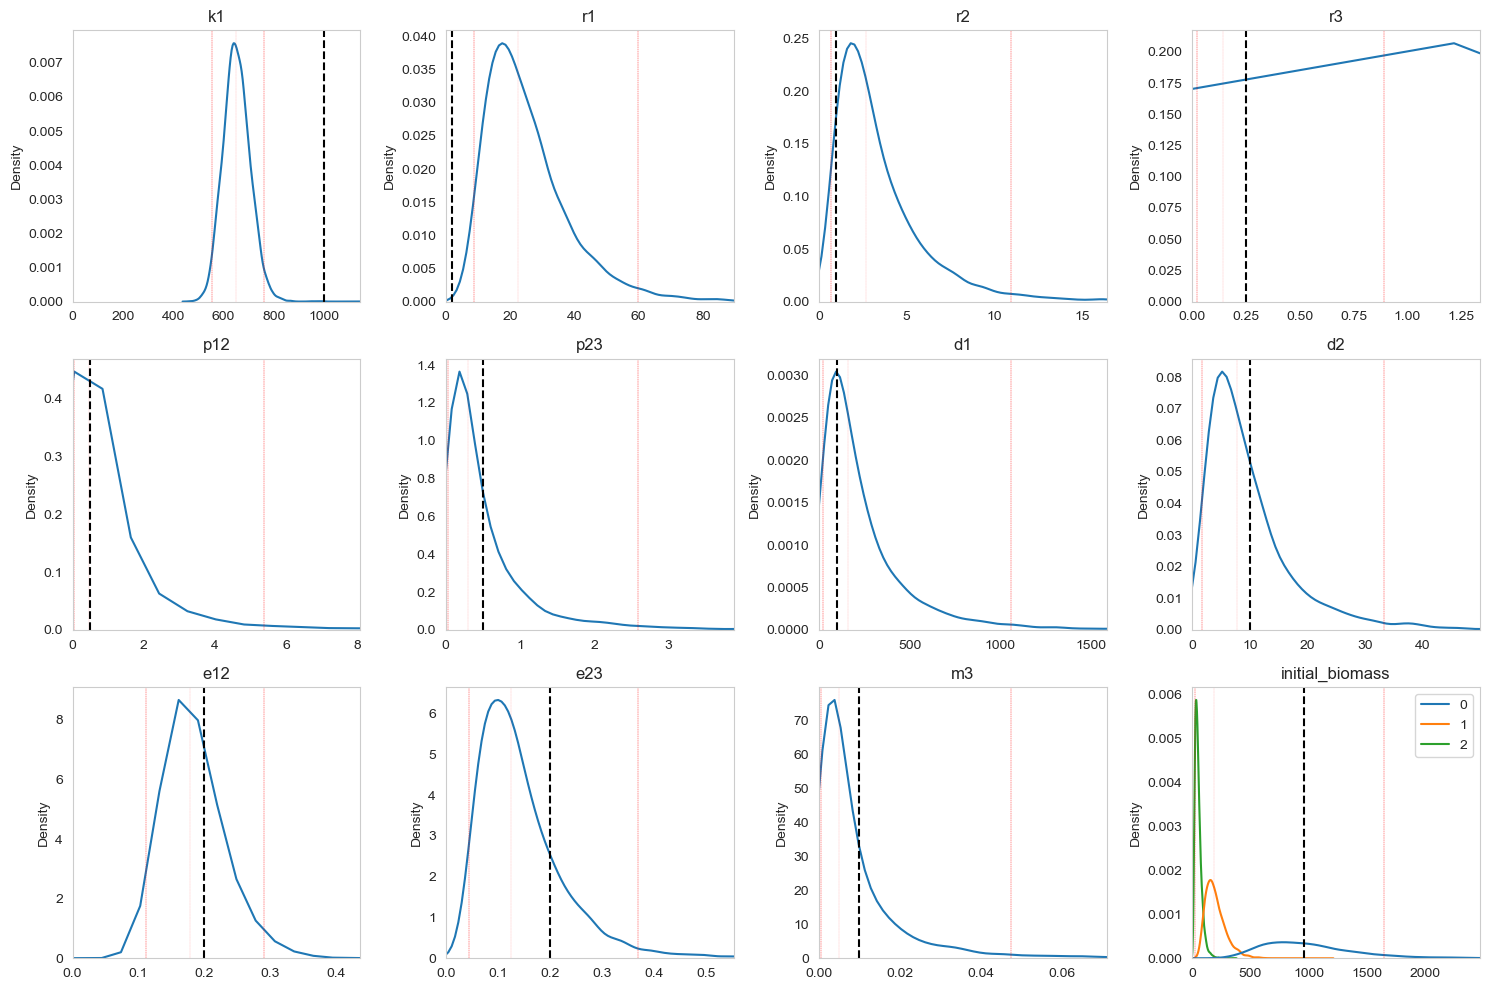

<Figure size 640x480 with 0 Axes>

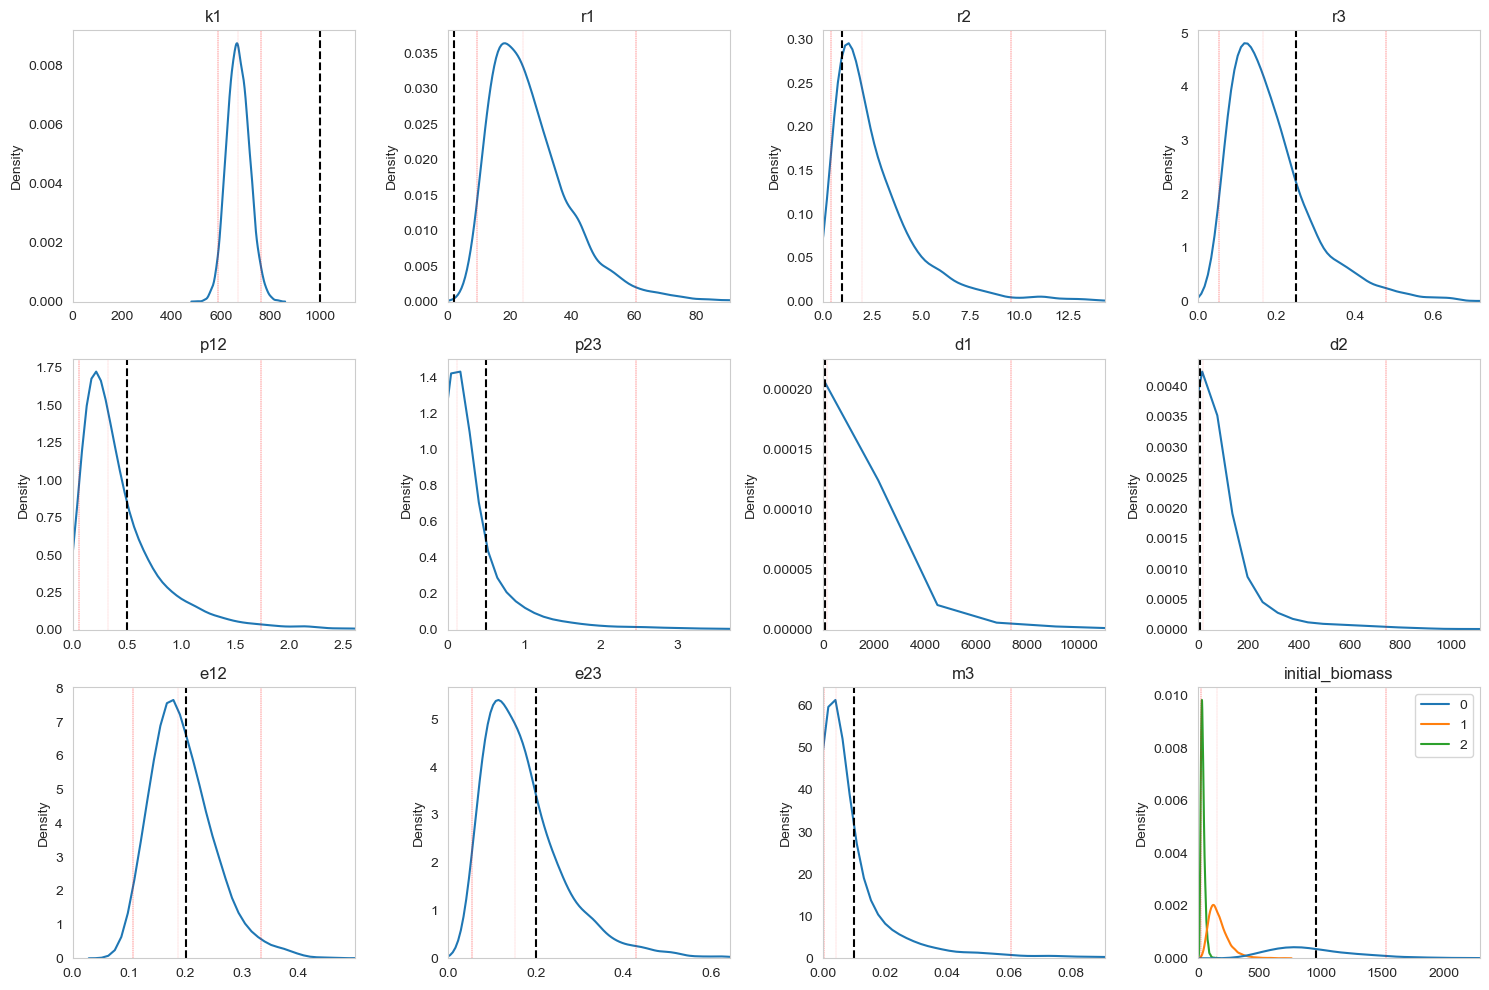

<Figure size 640x480 with 0 Axes>

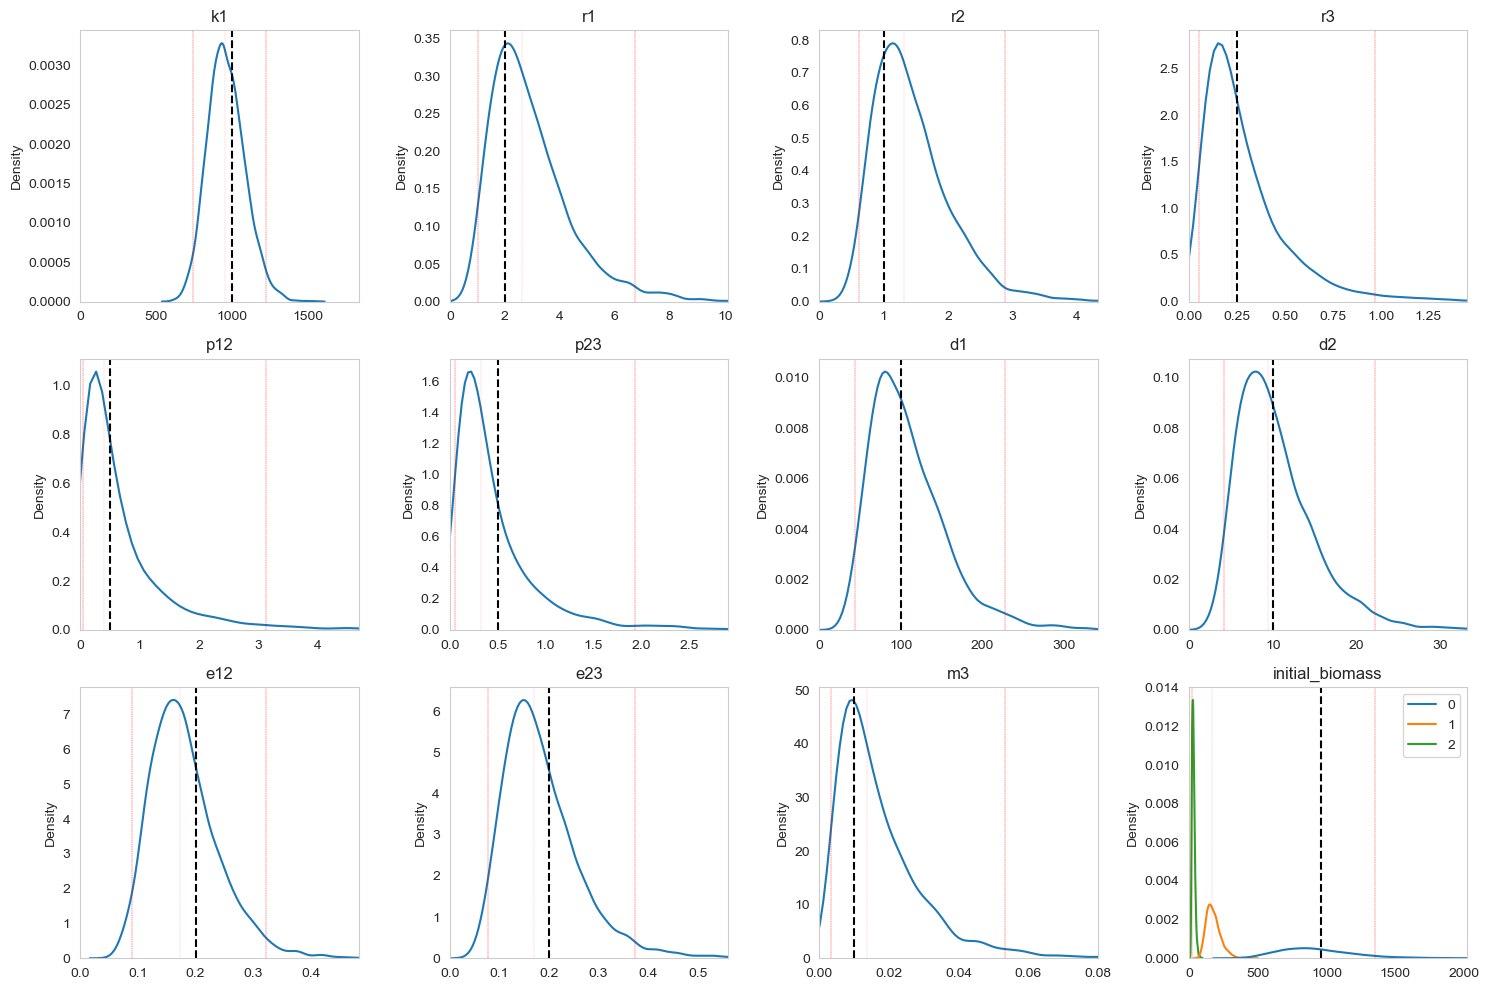

In [61]:
# DEBUG
len(targeted_guides)

tvs = {k: v.detach().clone() for k, v in TRUEVALS.items()} | {"initial_biomass": B_UNFISHED.detach().clone()[0]}  # HACK [0] to avoid drawing funky stuff.

plt.figure()
with pyro.plate("samples", 5000):
    plot_marginals(targeted_guides[0](), tvs)

plt.figure()
with pyro.plate("samples", 5000):
    plot_marginals(targeted_guides[1](), tvs)


plt.figure()
with pyro.plate("samples", 5000):
    plot_marginals(pamc_guide(), tvs)

In [ ]:
# DEBUG
# 1. create a pseudens that is just the full prior but with a log factor added to it for k1.
# 2. create a guide that uses our gmm guide thing.
# 3. build variational fitter
# 4. run the fitter.
# 5. plot the stuff.


def joint_prior():
    s = prior()
    s["initial_biomass"] = prior_initial_biomass()
    return s

def test_pseudens():
    s = joint_prior()
    pyro.factor("debugk1", -.5*((s["k1"] - 3000.)/100.)**2.)
    # pyro.factor("debugr1", -.5*((s["r1"] - 5.)/.003)**2.)

test_guide = GMMGuide(
    init_loc=prior_log_locs.detach().clone(),
    init_scale_vec=prior_log_scales.detach().clone(),
    ncomponents=5,
    model=test_pseudens
)

test_fitter = build_fit_variational_approximation(
    pseudo_density=test_pseudens,
    guide=test_guide,
    lr=1e-3
)

for i in range(10000):
    print(f"Iteration: {i:05d}", end="\r")
    test_fitter()

In [ ]:
# DEBUG
plt.figure()
with pyro.plate("samples", 5000):
    plot_marginals(test_guide(), tvs)